# Libraries Importation

In [1]:
import numpy as np 
import pandas as pd 
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Loading Dataset

In [3]:
dt_coh = pd.read_excel("OnlineRetail.xlsx")
dt_coh.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [4]:
dt_coh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# Data Cleaning and Preparation

In [5]:
dt_coh.isnull().sum()   # Checking for missing values

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
dt_coh.dropna(subset=['CustomerID'])  # Dropping missing values in CustomerID

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [11]:
 dt_coh.duplicated().sum() # Dropping duplicate values

5268

In [13]:
dt_coh.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


* Note that the minimum for the unit price is a negative value, and likewise, the minimum for the quantity is a negative value.


# Creating necessary label to do the Cohort analysis


<p> Billing period: A string representation of the year and month of a single transaction or invoice.</p>

<p> Cohort Group: A string representation of the year and month of a customer’s first purchase.  This label is common to all invoices for a particular customer.</p>
<p> Cohort Period or Cohort Index: Full representation of a client’s stage in their "lifespan". The number represents the number of months since the first purchase.</p>


* Customer retention is a very useful metric to understand how many of all customers are still active. Loyalty gives you the percentage of active customers compared to the total number of customers.

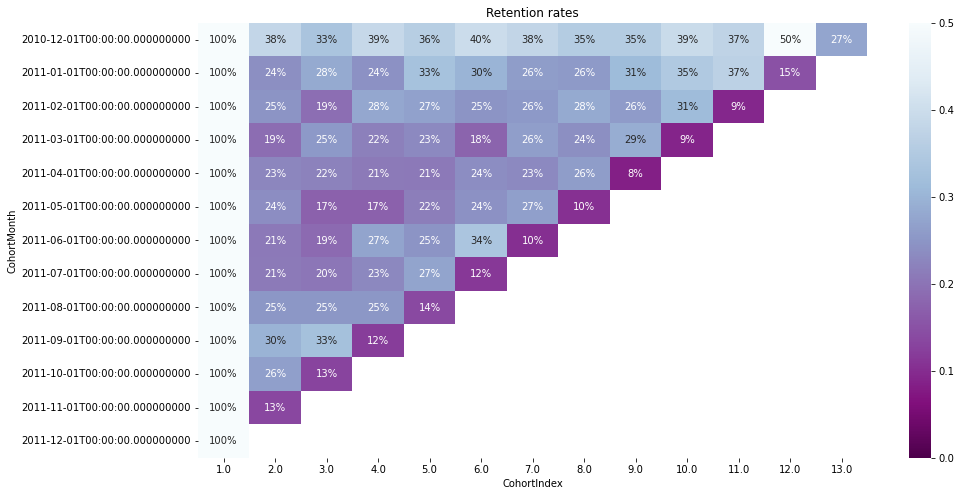

In [14]:
# Creating a function to get months and years
def get_month(x): return dt.datetime(x.year, x.month, 1)


dt_coh['InvoiceMonth'] = dt_coh['InvoiceDate'].apply(get_month)
grouping = dt_coh.groupby('CustomerID')['InvoiceMonth']
dt_coh['CohortMonth'] = grouping.transform('min')


def get_month_int(dframe, column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month, day


invoice_year, invoice_month, _ = get_month_int(dt_coh, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_month_int(dt_coh, 'CohortMonth')

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

dt_coh['CohortIndex'] = year_diff * 12 + month_diff + 1

#Count monthly active customers from each cohort
grouping = dt_coh.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)

# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# Retention table
cohort_size = cohort_counts.iloc[:, 0]

# axis=0 to ensure the divide along the row axis
retention = cohort_counts.divide(cohort_size, axis=0)
retention.round(3) * 100  # to show the number as percentage

#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data=retention, annot=True, fmt='.0%',
            vmin=0.0, vmax=0.5, cmap="BuPu_r")
plt.show()


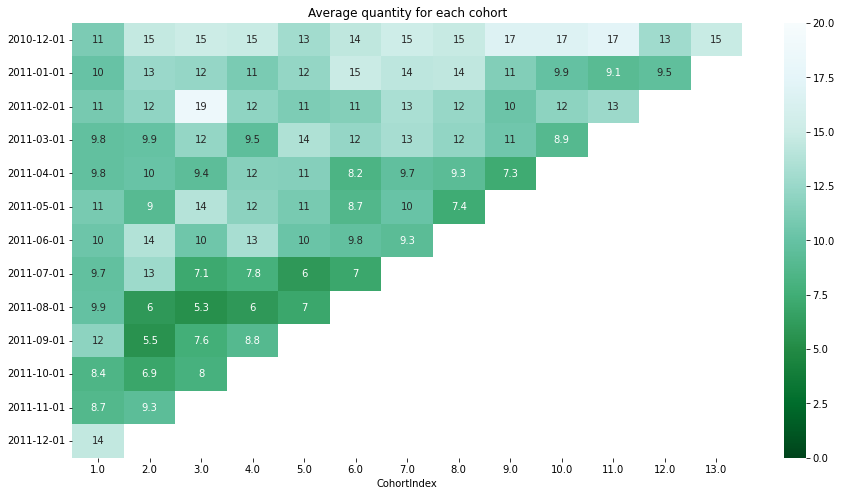

In [15]:
#Average quantity for each cohort
grouping = dt_coh.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='Quantity')
average_quantity.round(1)
average_quantity.index = average_quantity.index.date

#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Average quantity for each cohort')
sns.heatmap(data=average_quantity,annot = True,vmin = 0.0,vmax =20,cmap="BuGn_r")
plt.show()